In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qnmfits

from qnmfits import utils

The `sxs` package doesn't have functionality to download data from the [Ext-CCE waveform catalog](https://data.black-holes.org/waveforms/extcce_catalog.html). For convenience we provide a `cce` class which downloads CCE data at the recommended extraction radius and creates an [`AsymptoticBondiData`](https://scri.readthedocs.io/en/latest/tutorial_abd.html) object.

In [2]:
# Initialize the cce class
cce = qnmfits.cce()

# We specify the ID of the simulation we want to use. This will download the 
# simulation if it is not already on your computer, and store it in 
# qnmfits/data
abd = cce.load(1)

In [3]:
# We also store useful metadata in the abd object:
Mf = abd.metadata['remnant_mass']
chif = np.linalg.norm(abd.metadata['remnant_dimensionless_spin'])

In [4]:
h = abd.h

In [5]:
type(h)

scri.waveform_modes.WaveformModes

In [6]:
# We can extract individual spherical-harmonic modes like this:
h22 = h.data[:,h.index(2,2)]

# Shift the times
h.t -= h.t[np.argmax(np.abs(h22))]

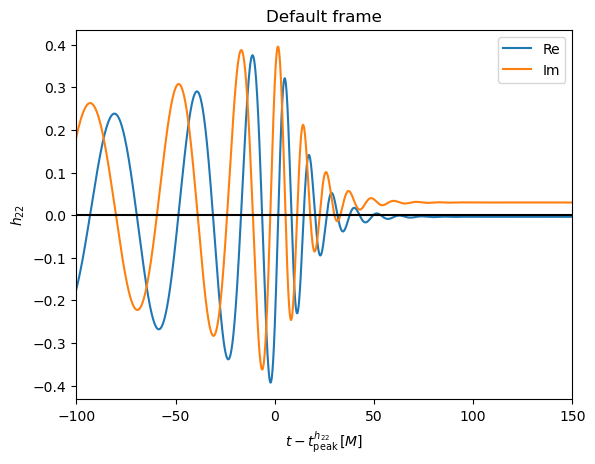

In [7]:
fig, ax = plt.subplots()

ax.set_title('Default frame')

ax.plot(h.t, np.real(h22), label='Re')
ax.plot(h.t, np.imag(h22), label='Im')

ax.axhline(0, c='k')

ax.set_xlabel('$t - t_\mathrm{peak}^{h_{22}}\, [M]$')
ax.set_ylabel('$h_{22}$')

ax.legend()

ax.set_xlim(-100,150);

In [8]:
abd_prime = utils.to_superrest_frame(abd, t0=300)

In [9]:
h_prime = abd_prime.h

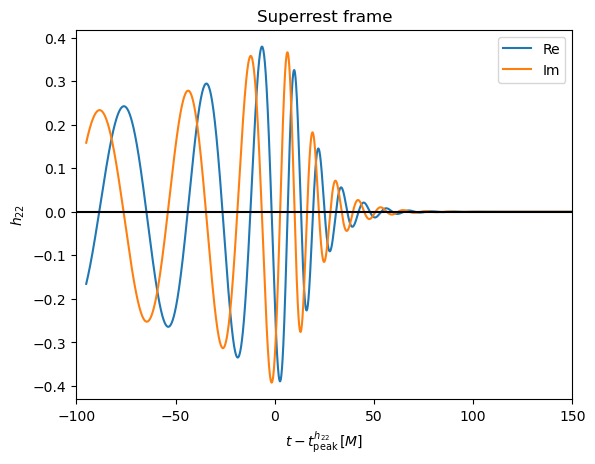

In [10]:
# We can extract individual spherical-harmonic modes like this:
h22_prime = h_prime.data[:,h_prime.index(2,2)]

# Shift the times
h_prime.t -= h_prime.t[np.argmax(np.abs(h22_prime))]

fig, ax = plt.subplots()

ax.set_title('Superrest frame')

ax.plot(h_prime.t, np.real(h22_prime), label='Re')
ax.plot(h_prime.t, np.imag(h22_prime), label='Im')

ax.axhline(0, c='k')

ax.set_xlabel('$t - t_\mathrm{peak}^{h_{22}}\, [M]$')
ax.set_ylabel('$h_{22}$')

ax.legend()

ax.set_xlim(-100,150);

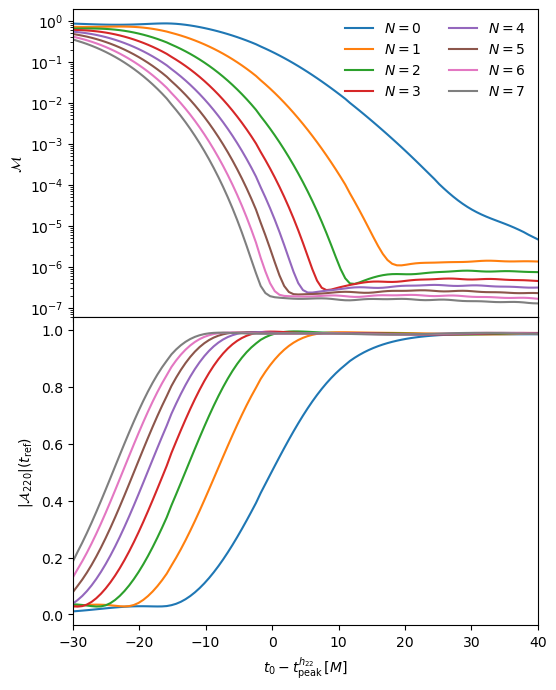

In [11]:
# Now perform fits with different numbers of overtones, from N=0 to N=7
qnm_list = [[(2,2,n,1) for n in range(N)] for N in range(1,7+2)]
spherical_modes = [(2,2)]

# The start times to use
t0_array = np.linspace(-30, 40, 100)

# We can specify a reference time for when the QNM amplitudes are defined. This
# is useful for investigating mode stability.
t_ref = 0

# Create figure
fig, axs = plt.subplots(2, 1, figsize=(6,8), sharex=True)
fig.subplots_adjust(hspace=0)

# We will store the fundamental mode amplitudes for each fit to investigate
# mode stability
A220_dict = {}

for N, qnms in enumerate(qnm_list):

    # Store the fundamental mode amplitude for each start time, and the 
    # mismatch
    A220_dict[N] = []
    mm_list = []

    for t0 in t0_array:
        best_fit = qnmfits.fit(
            data=h_prime,
            chif=chif,
            Mf=Mf,
            qnms=qnms,
            spherical_modes=spherical_modes,
            t0=t0,
            t_ref=t_ref
        )
        mm_list.append(best_fit['mismatch'])
        A220_dict[N].append(abs(best_fit['amplitudes'][2,2,0,1]))
        
    # Add to figure
    axs[0].semilogy(t0_array, mm_list, label=f'$N = {N}$')
    axs[1].plot(t0_array, A220_dict[N])
    
# Plot limits and labels
axs[0].set_xlim(t0_array[0], t0_array[-1])
axs[1].set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\, [M]$')
axs[0].set_ylabel('$\mathcal{M}$')
axs[1].set_ylabel('$|\mathcal{A}_{220}|(t_\mathrm{ref})$')

axs[0].legend(ncol=2, frameon=False);